Shape optimization
==================

## Overview 

In this tutorial, we will optimize a triangle mesh to match a target shape specfied using a set of reference renderings.

Gradients with regards to vertex positions are typically extremely sparse, since only vertices located on visibility discontinuities receive a contribution. As a consequence, naively optimizing a triangle mesh generally results in horrible, tangled meshes.

To avoid this, we will use the method from the paper "[Large Steps in Inverse Rendering of Geometry][1]". This method optimizes a latent variable that enables smoother gradients.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Use the "large steps" algorithm to optimize a shape</li>
  <li>Use remeshing to refine the optimized shape</li>
</ul>
    
</div>

[1]: http://rgl.epfl.ch/publications/Nicolet2021Large

## Setup

As always, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt # We'll also want to plot some outputs
import os

mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

## Setting up sensors

In order to accurately recover a shape, we need several reference renderings, taken from different viewpoints. Similar to the [volume optimisation tutorial][1], we render each viewpoint separately during the optimisation.

Note that we also have to set the `sample_border` flag to `True` for the [<code>hdrfilm</code>][2] plugin. By enabling this option, Mitsuba will render regions slightly beyond the film's boundaries, enabling us to track objects that enter or exit the frame.

Here we will generate 8 viewpoints evenly distributed on the sphere, using the [Fibonacci lattice][3].

[1]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/volume_optimization.html#Optimization
[2]: https://mitsuba.readthedocs.io/en/stable/src/generated/plugins_films.html#high-dynamic-range-film-hdrfilm
[3]: http://extremelearning.com.au/evenly-distributing-points-on-a-sphere/

In [2]:
from mitsuba import ScalarTransform4f as T

sensor_count = 8
sensors = []

golden_ratio = (1 + 5**0.5)/2
for i in range(sensor_count):
    theta = 2 * dr.pi * i / golden_ratio
    phi = dr.acos(1 - 2*(i+0.5)/sensor_count)
    
    d = 5
    origin = [
        d * dr.cos(theta) * dr.sin(phi),
        d * dr.sin(theta) * dr.sin(phi),
        d * dr.cos(phi)
    ]
    
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': T().look_at(target=[0, 0, 0], origin=origin, up=[0, 1, 0]),
        'film': {
            'type': 'hdrfilm',
            'width': 256, 'height': 256,
            'filter': {'type': 'gaussian'},
            'sample_border': True,
        },     
        'sampler': {
            'type': 'independent',
            'sample_count': 128
        },
    }))

## Scene construction

Let's now generate the reference renderings. We will load a scene with tthe target mesh and an environment map. Note the use of the `direct_reparam` integrator, that properly accounts for visibility discontinuities when differentiating, as in the [object pose estimation tutorial][1]. There won't be many shadows in our scene intitially, so let's turn off indirect visibility effects in the integrator to speed the optimization up.

[1]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/object_pose_estimation.html

In [3]:
scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_projective',
        # Indirect visibility effects aren't that important here
        # let's turn them off and save some computation time
        'sppi': 0, 
    },
    'emitter': {
        'type': 'envmap',
        'filename': "../scenes/textures/envmap2.exr",
    },
    'shape': {
        'type': 'ply',
        'filename': "../scenes/meshes/suzanne.ply",
        'bsdf': {'type': 'diffuse'}
    }
}

scene_target = mi.load_dict(scene_dict)

We can now generate the reference image, our goal is to reconstruct [Blender's Suzanne][1].

[1]: https://en.wikipedia.org/wiki/Blender_(software)

In [4]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')

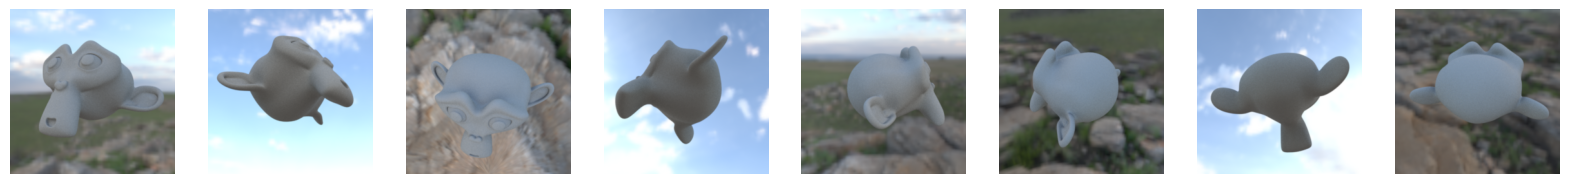

In [5]:
ref_images = [mi.render(scene_target, sensor=sensors[i], spp=256) for i in range(sensor_count)]
plot_images(ref_images)

The starting geometry which we'll optimize is a relatively dense sphere. More challenging scenes and target shapes might require a better initialization.

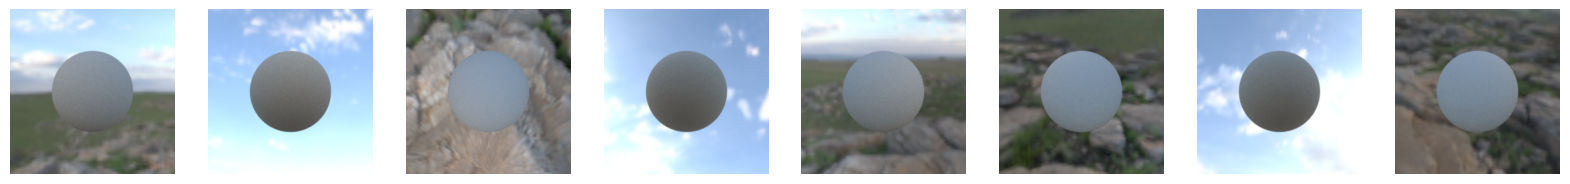

In [6]:
scene_dict['shape']['filename'] = '../scenes/meshes/ico_10k.ply'
scene_source = mi.load_dict(scene_dict)

init_imgs = [mi.render(scene_source, sensor=sensors[i], spp=128) for i in range(sensor_count)]
plot_images(init_imgs)

## Naive optimization

It is tempting to apply the same steps as in previous tutorials, i.e. simply render the scene, compute a loss, and differentiate. Let's try that first.

As per usual, all that is needed is an `Optimizer` and a simple optimization loop.

In [7]:
params = mi.traverse(scene_source)
opt = mi.ad.Adam(lr=3e-2)
opt['shape.vertex_positions'] = params['shape.vertex_positions']

In [8]:
for it in range(5):
    total_loss = mi.Float(0.0)

    for sensor_idx in range(sensor_count):
        params.update(opt)
        
        img = mi.render(scene_source, params, sensor=sensors[sensor_idx], seed=it)

        # L2 Loss
        loss = dr.mean(dr.square(img - ref_images[sensor_idx]), axis=None)
        dr.backward(loss)
    
        opt.step()

        total_loss += loss
    
    print(f"Iteration {1+it:03d}: Loss = {total_loss}", end='\r')

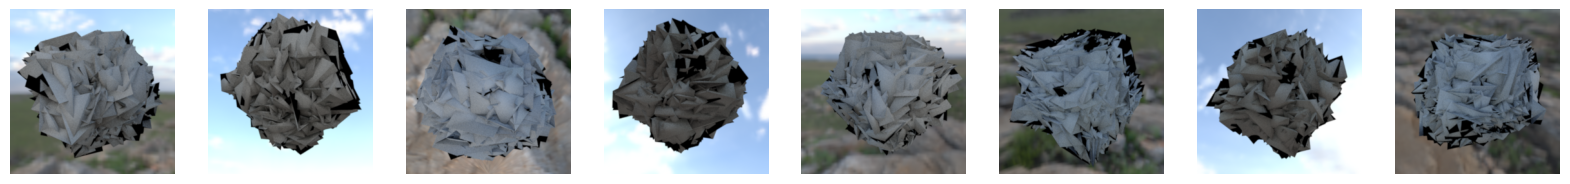

In [9]:
final_imgs = [mi.render(scene_source, sensor=sensors[i], spp=128) for i in range(sensor_count)]
plot_images(final_imgs)

As you can see, even after only a few steps, this approach produces an unusable mess of triangles. This is a consequence of the sparsity of the visibility-related gradients. Indeed, these are only present on edges that are on the silhouette of the mesh for a given viewpoint.

In [10]:
# Reset the scene
scene_source = mi.load_dict(scene_dict)
params = mi.traverse(scene_source)

## Large Steps Optimization

Rather than directly optimizing cartesian vertex coordinates, the work of [[Nicolet et al. 2021]][1] "_Large Steps in Inverse Rendering of Geometry_" introduces a latent representation that improves the smoothnes of gradients. In short, a latent variable $u$ is defined as $u = (I + \lambda L) v$, where $v$ denotes the vertex positions, $L$ is the (combinatorial) Laplacian of the given mesh, and $\lambda$ is a user-defined hyper-parameter. Intuitively, this parameter $\lambda$ defines by how much the gradients should be smoothed out on the surface.

This approach is readily available in Mitsuba in the `mi.ad.LargeSteps` class. It requires [<code>cholespy</code>][1], a Python package to solve sparse linear systems with Cholesky factorisations.

[1]: http://rgl.epfl.ch/publications/Nicolet2021Large
[2]: https://github.com/rgl-epfl/cholespy

In [11]:
!pip install cholespy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.8 -m pip install --upgrade pip


The `LargeSteps` helper is instanciated from the starting shapes' vertex positions and faces. If the mesh has duplicate vertices (e.g. due to face normals or UV seams), it will internally convert the mesh to a "unique" representation.

In [12]:
lambda_ = 25
ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)

We also use a slightly modified version of the [<code>Adam</code>][1] optimizer, that uses a uniform second moment for all parameters. This can be done by setting `uniform=True` when instantiating the optimizer.

[1]: https://mitsuba.readthedocs.io/en/stable/src/api_reference.html#mitsuba.ad.Adam

In [13]:
opt = mi.ad.Adam(lr=1e-1, uniform=True)

The `LargeSteps` class has a couple utility methods that can be used to convert back and forth between cartesian and differential representation of the vertex coordinates. The `LargeSteps.to_differential` method is used here to initialize the latent variable.

In [14]:
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

The optimisation loop must also be slighlty changed. We now need to update the shape using the latent variable, this additional step can be done by using `LargeSteps.from_differential`.

In [15]:
iterations = 100 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(iterations):
    total_loss = mi.Float(0.0)
    
    for sensor_idx in range(sensor_count):
        # Retrieve the vertex positions from the latent variable
        params['shape.vertex_positions'] = ls.from_differential(opt['u'])
        params.update()
        
        img = mi.render(scene_source, params, sensor=sensors[sensor_idx], seed=it)
        
        # L1 Loss
        loss = dr.mean(dr.abs(img - ref_images[sensor_idx]), axis=None)
        
        dr.backward(loss)
        opt.step()
        
        total_loss += loss
        
    print(f"Iteration {1+it:03d}: Loss = {total_loss}", end='\r')

## Intermediate result

In [16]:
# Update the mesh after the last iteration's gradient step
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

Let us again plot the result of our optimization.

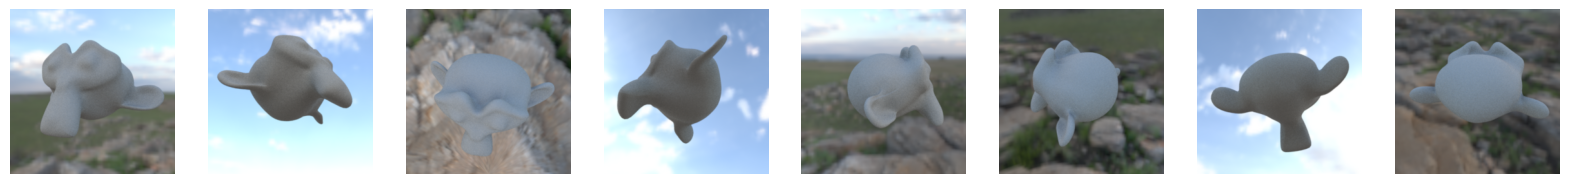

In [17]:
final_imgs = [mi.render(scene_source, sensor=sensors[i], spp=128) for i in range(sensor_count)]
plot_images(final_imgs)

## Remeshing

The result above can be further improved with the help of remeshing. By increasing the tesselation of the mesh, we will be able to recover more details of the target shape. Intuitively, the intent of this step is similar to other "coarse-to-fine" optimization strategies. For example, in the [caustics][1] or the [volume optimization][2] tutorial we increase the resolution of texture that is being optimized over time.

We will use the Botsch-Kobbelt remeshing algorithm provided by the `gpytoolbox` package:

[1]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/caustics_optimization.html
[2]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/volume_optimization.html

In [ ]:
!pip install gpytoolbox;

Since the `gpytoolbox` package expects NumPy arrays, we will first convert the mesh data to the correct format.

In [19]:
import numpy as np
v_np = params['shape.vertex_positions'].numpy().reshape((-1,3)).astype(np.float64)
f_np = params['shape.faces'].numpy().reshape((-1,3))

The Botsch-Kobbelt remeshing algorithm takes a "target edge length" as input argument. This controls the desired tesselation of the mesh. Since we want to increase resolution, we will set this as half of the mean edge length of the current mesh.

In [20]:
# Compute average edge length
l0 = np.linalg.norm(v_np[f_np[:,0]] - v_np[f_np[:,1]], axis=1)
l1 = np.linalg.norm(v_np[f_np[:,1]] - v_np[f_np[:,2]], axis=1)
l2 = np.linalg.norm(v_np[f_np[:,2]] - v_np[f_np[:,0]], axis=1)

target_l = np.mean([l0, l1, l2]) / 2

We can now run the Botsch-Kobbelt remeshing algorithm. It runs for a user-specified number of iterations, which we set to 5 here. Further details about this algorithm can be found it the package's [documentation][1].

[1]: https://gpytoolbox.org/0.1.0/remesh_botsch/

In [21]:
from gpytoolbox import remesh_botsch

v_new, f_new = remesh_botsch(v_np, f_np, i=5, h=target_l, project=True)

The new vertices and faces must now be passed to our Mitsuba `Mesh`. If the mesh has other attributes (e.g. UV coordinates), they also need to be updated. By default, Mitsuba will reset these to 0 if the vertex or face count is altered.

In [22]:
params['shape.vertex_positions'] = mi.Float(v_new.flatten().astype(np.float32))
params['shape.faces'] = mi.Int(f_new.flatten())
params.update();

Since the mesh topology has changed, we also need to compute a new latent variable.

In [23]:
ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)
opt = mi.ad.Adam(lr=1e-1, uniform=True)
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

We had disabled indirect visibility derivatives so far, as they weren't really needed. However, the mesh now does shadow itself a fair amount, indirect visibility effects became more important and may help with optimizing the last few details of the shape.

In [24]:
integrator = mi.load_dict({
    'type': 'direct_projective'
})

Let's continue the optimization.

In [25]:
iterations = 100 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(iterations):
    total_loss = mi.Float(0.0)
    for sensor_idx in range(sensor_count):
        # Retrieve the vertex positions from the latent variable
        params['shape.vertex_positions'] = ls.from_differential(opt['u'])
        params.update()

        img = mi.render(scene_source, params, sensor=sensors[sensor_idx], seed=it, integrator=integrator)
    
        # L1 Loss
        loss = dr.mean(dr.abs(img - ref_images[sensor_idx]), axis=None)
        dr.backward(loss)
        total_loss += loss
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {total_loss}", end='\r')

## Final result

We recover the final state from the latent variable:

In [26]:
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

Finally, let's compare our end result (bottom) to our reference views (top).

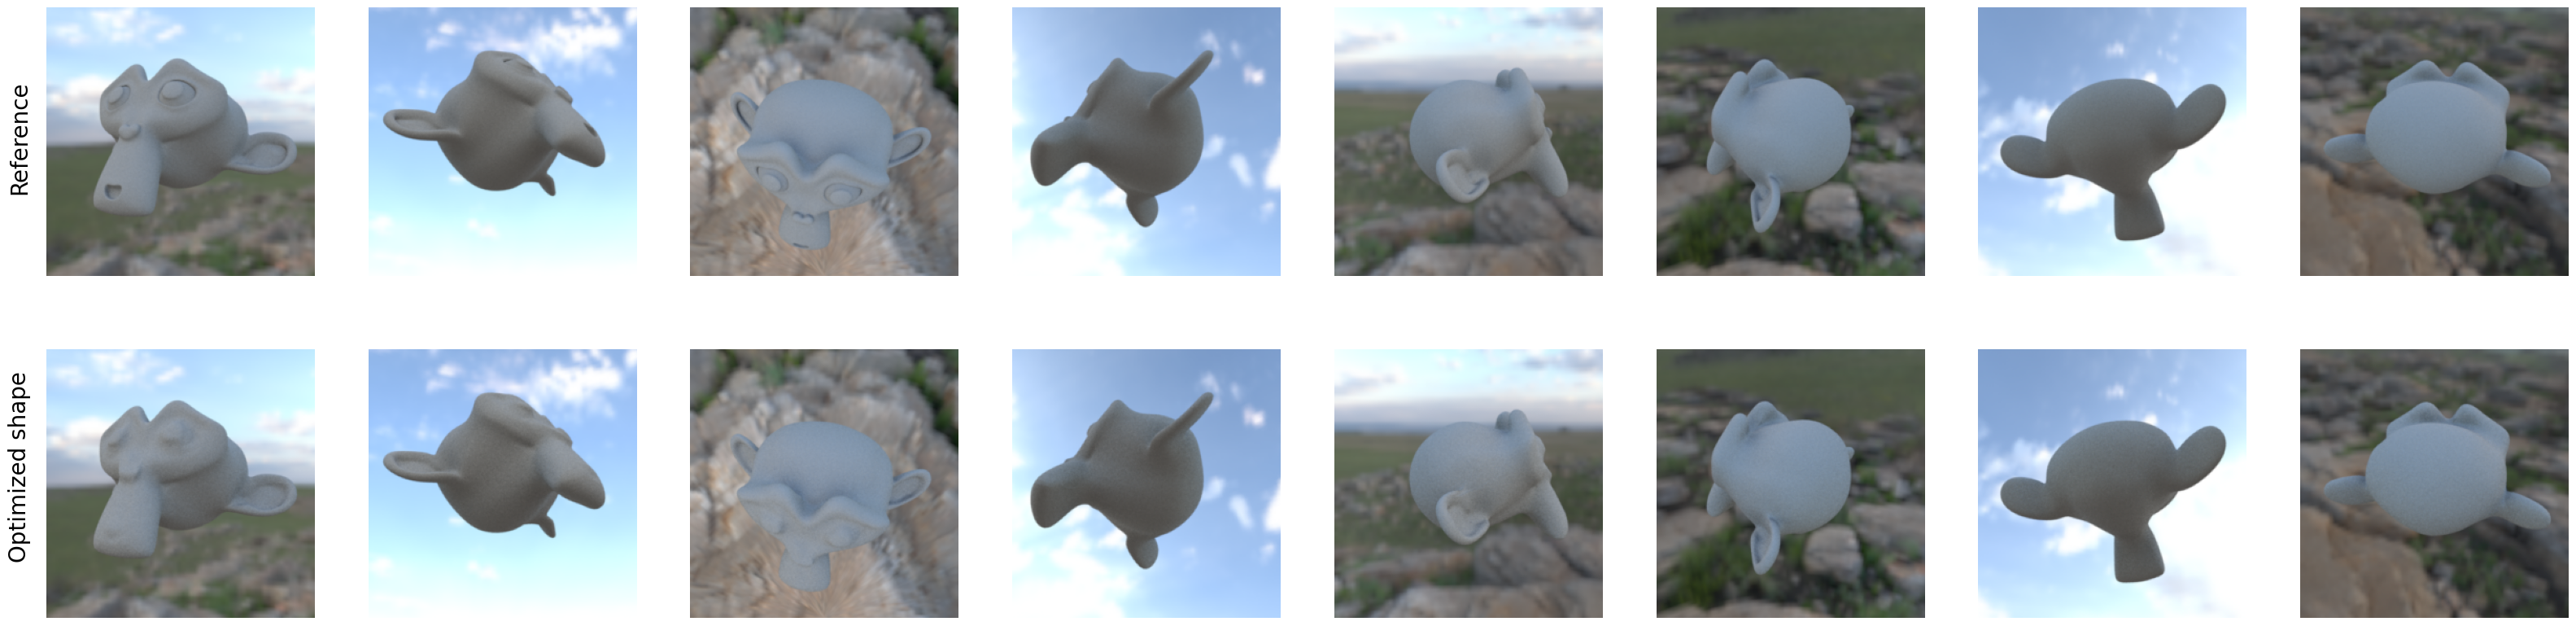

In [27]:
final_imgs = [mi.render(scene_source, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, ax = plt.subplots(nrows=2, ncols=sensor_count, figsize=(5*sensor_count, 10))
ax[0][0].set_title("Reference", y=0.3, x=-0.1, rotation=90, fontsize=20)
ax[1][0].set_title("Optimized shape", y=0.2, x=-0.1, rotation=90, fontsize=20)
for i in range(sensor_count):
    ax[0][i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    ax[0][i].axis('off')
    ax[1][i].imshow(mi.util.convert_to_bitmap(final_imgs[i]))
    ax[1][i].axis('off')

Note that the results could be further improved by e.g. using more input views, or using a less agressive step size and more iterations.

## See also

- [<code>mitsuba.ad.LargeSteps</code>][1]
- [<code>direct_projective</code> plugin][2]

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.LargeSteps
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#direct-illumination-projective-sampling-direct-projective